# **Parkinson Disease Detection using Transfer Learning**
##### In this project, we focus on classifying handwriting images that shows specific patterns, such as spirals and waves.
##### This approach demonstrates the practical application of computer vision in real-world healthcare, specifically for early detection of Parkinson’s disease through analysis of handwriting patterns.

In [1]:
#Necessary libraries to import
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess


**1. DATA COLLECTION**


*   data load from drive
*   set paths for the images data




In [2]:
#Mount google drive to this file
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Function to load images and assign labels (0 for Healthy, 1 for Parkinson)
def load_images(path, label):
    images = []
    labels = []

    for img_name in tqdm(os.listdir(path)):
        if img_name.endswith('.png'):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Compatible with ResNet/Inception
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

# Setting paths to the healthy and Parkinson's datasets
#base directory
base_dir = '/content/drive/My Drive/ParkinsonDiseaseDetection/dataset'
healthy_dir = os.path.join(base_dir, 'Healthy')
parkinson_dir = os.path.join(base_dir, 'Parkinson')


print("Loading Healthy Images...")
healthy_images, healthy_labels = load_images(healthy_dir, 0)

print("Loading Parkinson Images...")
parkinson_images, parkinson_labels = load_images(parkinson_dir, 1)

Loading Healthy Images...


100%|██████████| 1632/1632 [00:35<00:00, 46.44it/s]


Loading Parkinson Images...


100%|██████████| 604/604 [00:16<00:00, 37.06it/s]


In [4]:
# Combining the healthy and Parkinson's images and labels into single arrays
# Combine
X = np.concatenate((healthy_images, parkinson_images), axis=0)
y = np.concatenate((healthy_labels, parkinson_labels), axis=0)

# Splitting the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

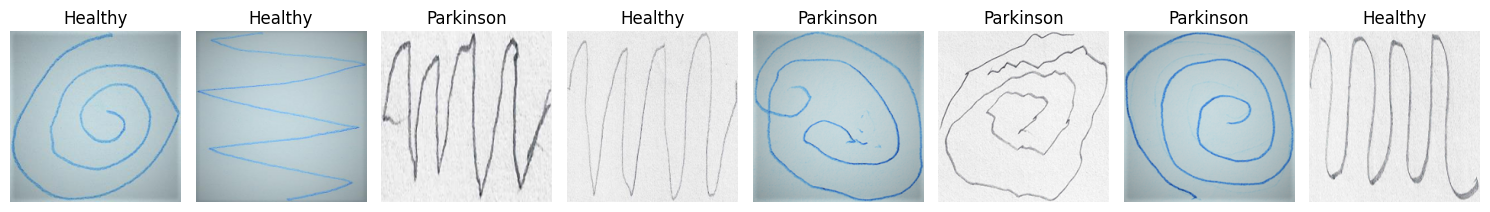

In [5]:
def show_sample_images(X, y, num_images=8):
    healthy_images = [X[i] for i in range(len(y)) if y[i] == 0]
    parkinson_images = [X[i] for i in range(len(y)) if y[i] == 1]

    healthy_images = np.array(healthy_images)
    parkinson_images = np.array(parkinson_images)

    selected_healthy_images = healthy_images[np.random.choice(healthy_images.shape[0], num_images // 2, replace=False)]
    selected_parkinson_images = parkinson_images[np.random.choice(parkinson_images.shape[0], num_images // 2, replace=False)]

    selected_images = np.concatenate((selected_healthy_images, selected_parkinson_images), axis=0)
    selected_labels = [0] * (num_images // 2) + [1] * (num_images // 2)

    combined = list(zip(selected_images, selected_labels))
    np.random.shuffle(combined)
    selected_images, selected_labels = zip(*combined)

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(selected_images[i], cv2.COLOR_BGR2RGB))
        plt.title("Healthy" if selected_labels[i] == 0 else "Parkinson")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(X, y, num_images=8)

# **Training the model**

*   preprocessing
*   data augmentation
*   freezing layers
*   binary classification





In [6]:

def train_model(base_model, preprocess_fn, model_name):
    print(f" Training: {model_name}")

    # Preprocess
    X_train_prep = np.array([preprocess_fn(img.astype('float32')) for img in X_train])
    X_test_prep = np.array([preprocess_fn(img.astype('float32')) for img in X_test])


    # Data Augmentation
    train_gen = ImageDataGenerator(rotation_range=15, zoom_range=0.1, horizontal_flip=True)
    test_gen = ImageDataGenerator()

    train_data = train_gen.flow(X_train_prep, y_train, batch_size=32)
    test_data = test_gen.flow(X_test_prep, y_test, batch_size=32)


    # Freeze layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)


    #Binary Classification
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f"{model_name}.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=10,
        callbacks=callbacks
    )

    # Evaluation
    y_pred_prob = model.predict(test_data)
    y_pred = (y_pred_prob > 0.5).astype("int32")


    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, target_names=['Healthy', 'Parkinson'])

    return acc, cm, cr, history

In [7]:
# TRAIN INCEPTIONV3

inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_results = train_model(inception_base, inception_preprocess, "InceptionV3")


# TRAIN RESNET50

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_results = train_model(resnet_base, resnet_preprocess, "ResNet50")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 Training: InceptionV3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.7855 - loss: 0.5189
Epoch 1: val_accuracy improved from -inf to 0.88839, saving model to InceptionV3.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 67s 749ms/step - accuracy: 0.7865 - loss: 0.5175 - val_accuracy: 0.8884 - val_loss: 0.4475
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9262 - loss: 0.2182
Epoch 2: val_accuracy improved from 0.88839 to 0.92857, saving model to InceptionV3.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 434ms/step - accuracy: 0.9261 - loss: 0.2186 - val_accuracy: 0.9286 - val_loss: 0.2217
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9156 - loss: 0.2184
Epoch 3: val_accuracy did not improve from 0.92857
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 405ms/step - accuracy: 0.9158 - loss: 0.2180 - val_accuracy: 0.8862 - val_loss: 0.2975
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9299 - loss: 0.1736
Epoch 4: val_accuracy improved from 0.92857 to 0.93080, saving model to InceptionV3.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 423ms/step - accuracy: 0.9299 - loss: 0.1738 - val_accuracy: 0.9308 - val_loss: 0.1880
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9329 - loss: 0.1653
Epoch 5: val_accuracy did not improve from 0.93080
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 406ms/step - accuracy: 0.9329 - loss: 0.1654 - val_accuracy: 0.9219 - val_loss: 0.2193
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9397 - loss: 0.1503
Epoch 6: val_accuracy improved from 0.93080 to 0.94866, saving model to InceptionV3.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 400ms/step - accuracy: 0.9398 - loss: 0.1503 - val_accuracy: 0.9487 - val_loss: 0.1397
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9610 - loss: 0.1217
Epoch 7: val_accuracy did not improve from 0.94866
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - accuracy: 0.9609 - loss: 0.1218 - val_accuracy: 0.9487 - val_loss: 0.1318
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9656 - loss: 0.0858
Epoch 8: val_accuracy did not improve from 0.94866
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 399ms/step - accuracy: 0.9655 - loss: 0.0862 - val_accuracy: 0.9397 - val_loss: 0.1863
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9568 - loss: 0.1303
Epoch 9: val_accuracy improved from 0.94866 to 0.95312, saving model to InceptionV3.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 395ms/step - accuracy: 0.9567 - loss: 0.1305 - val_accuracy: 0.9531 - val_loss: 0.1567
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9623 - loss: 0.1019
Epoch 10: val_accuracy did not improve from 0.95312
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.9623 - loss: 0.1020 - val_accuracy: 0.9397 - val_loss: 0.1819
Restoring model weights from the end of the best epoch: 7.
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 Training: ResNet50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.7812 - loss: 0.6440
Epoch 1: val_accuracy improved from -inf to 0.83036, saving model to ResNet50.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 706ms/step - accuracy: 0.7823 - loss: 0.6407 - val_accuracy: 0.8304 - val_loss: 21.7287
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9076 - loss: 0.2398
Epoch 2: val_accuracy improved from 0.83036 to 0.90179, saving model to ResNet50.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 445ms/step - accuracy: 0.9076 - loss: 0.2398 - val_accuracy: 0.9018 - val_loss: 3.5345
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9350 - loss: 0.1795
Epoch 3: val_accuracy improved from 0.90179 to 0.93527, saving model to ResNet50.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 437ms/step - accuracy: 0.9349 - loss: 0.1796 - val_accuracy: 0.9353 - val_loss: 0.4976
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9394 - loss: 0.1635
Epoch 4: val_accuracy improved from 0.93527 to 0.93973, saving model to ResNet50.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 420ms/step - accuracy: 0.9395 - loss: 0.1632 - val_accuracy: 0.9397 - val_loss: 0.2810
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9471 - loss: 0.1365
Epoch 5: val_accuracy did not improve from 0.93973
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.9471 - loss: 0.1366 - val_accuracy: 0.9330 - val_loss: 0.2830
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9626 - loss: 0.1297
Epoch 6: val_accuracy did not improve from 0.93973
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - accuracy: 0.9626 - loss: 0.1295 - val_accuracy: 0.9353 - val_loss: 0.1737
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9633 - loss: 0.1170
Epoch 7: val_accuracy did not improve from 0.93973
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 417ms/step - accuracy: 0.9633 - loss: 0.1168 - val_accuracy: 0.9353 - val_loss: 0.2469
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9766 - loss: 0.0681
Epoch 8: val_accuracy did not i

56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.9650 - loss: 0.1085 - val_accuracy: 0.9621 - val_loss: 0.1042
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9780 - loss: 0.0561
Epoch 10: val_accuracy did not improve from 0.96205
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.9780 - loss: 0.0563 - val_accuracy: 0.9420 - val_loss: 0.1211
Restoring model weights from the end of the best epoch: 9.
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step


In [8]:
# Function to plot the confusion matrix
def plot_cm(cm, model_name):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [9]:
# Store results with model names
results = [
    ("InceptionV3", *inception_results),
    ("ResNet50", *resnet_results)
]

# Initialize containers to store data for plotting and evaluation
model_names = []
accuracies = []
loss_histories = {}
acc_histories = {}
conf_matrices = {}
class_reports = {}

# Collecting evaluation data for each model
for model_name, acc, cm, cr, history in results:
    model_names.append(model_name)
    accuracies.append(acc)
    conf_matrices[model_name] = cm
    class_reports[model_name] = cr
    loss_histories[model_name] = history.history['loss'], history.history['val_loss']
    acc_histories[model_name] = history.history['accuracy'], history.history['val_accuracy']




============================================================\ Model: InceptionV3
 Accuracy: 0.6272

 Classification Report:
               precision    recall  f1-score   support

     Healthy       0.74      0.76      0.75       327
   Parkinson       0.29      0.26      0.27       121

    accuracy                           0.63       448
   macro avg       0.51      0.51      0.51       448
weighted avg       0.61      0.63      0.62       448



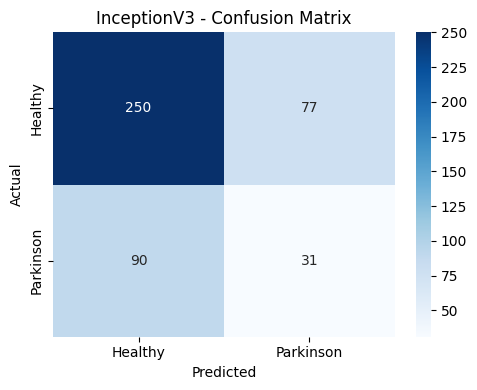


============================================================\ Model: ResNet50
 Accuracy: 0.5915

 Classification Report:
               precision    recall  f1-score   support

     Healthy       0.71      0.74      0.73       327
   Parkinson       0.21      0.18      0.19       121

    accuracy                           0.59       448
   macro avg       0.46      0.46      0.46       448
weighted avg       0.57      0.59      0.58       448



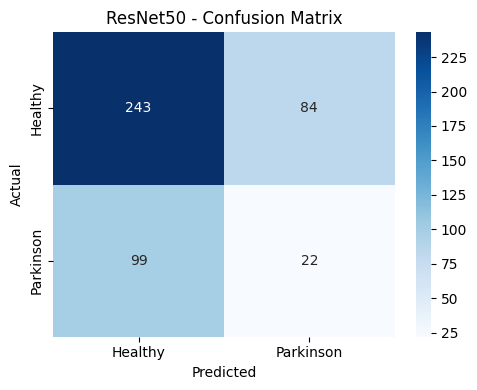

In [10]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Healthy', 'Parkinson'],
                yticklabels=['Healthy', 'Parkinson'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


for name in model_names:
    print(f"\n{'='*60}\ Model: {name}")
    print(f" Accuracy: {accuracies[model_names.index(name)]:.4f}")
    print("\n Classification Report:\n", class_reports[name])
    plot_confusion_matrix(conf_matrices[name], name)




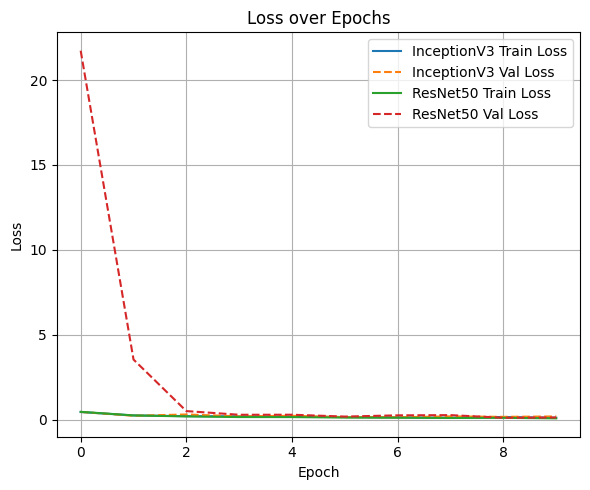

In [11]:
plt.figure(figsize=(6, 5))
for name in model_names:
    train_loss, val_loss = loss_histories[name]
    plt.plot(train_loss, label=f'{name} Train Loss')
    plt.plot(val_loss, linestyle='--', label=f'{name} Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



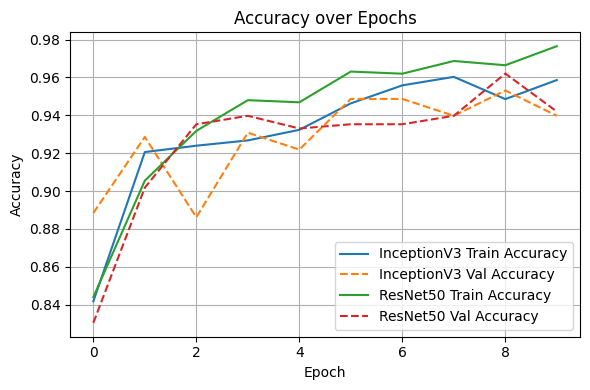

In [12]:
plt.figure(figsize=(6, 4))
for name in model_names:
    train_acc, val_acc = acc_histories[name]
    plt.plot(train_acc, label=f'{name} Train Accuracy')
    plt.plot(val_acc, linestyle='--', label=f'{name} Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

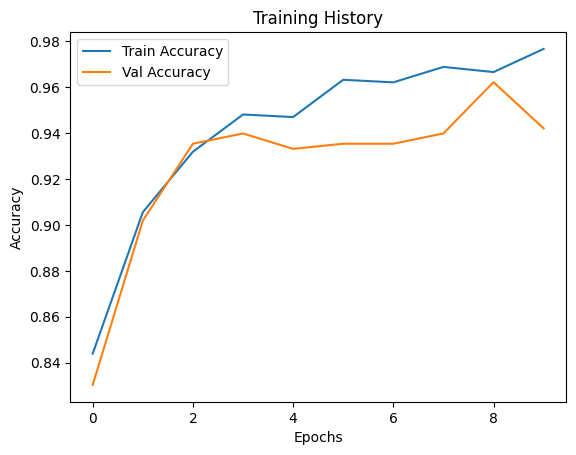

In [13]:
# Plot training curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

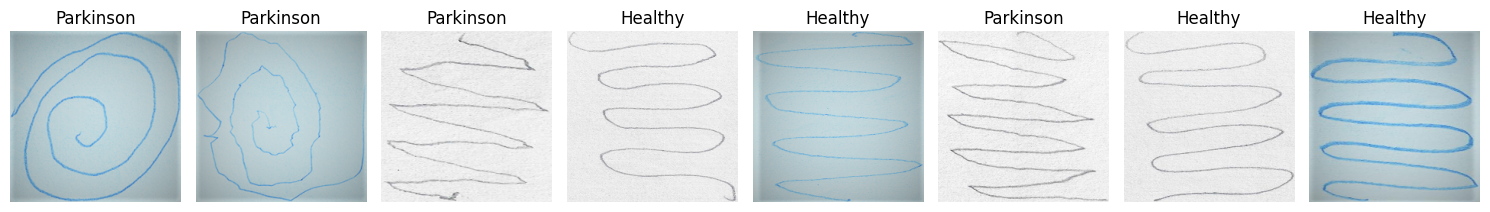

In [14]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def show_sample_images(X, y, num_images=8):
    healthy_images = [X[i] for i in range(len(y)) if y[i] == 0]
    parkinson_images = [X[i] for i in range(len(y)) if y[i] == 1]

    healthy_images = np.array(healthy_images)
    parkinson_images = np.array(parkinson_images)

    selected_healthy_images = healthy_images[np.random.choice(healthy_images.shape[0], num_images // 2, replace=False)]
    selected_parkinson_images = parkinson_images[np.random.choice(parkinson_images.shape[0], num_images // 2, replace=False)]

    selected_images = np.concatenate((selected_healthy_images, selected_parkinson_images), axis=0)
    selected_labels = [0] * (num_images // 2) + [1] * (num_images // 2)

    combined = list(zip(selected_images, selected_labels))
    np.random.shuffle(combined)
    selected_images, selected_labels = zip(*combined)

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(selected_images[i], cv2.COLOR_BGR2RGB))
        plt.title("Healthy" if selected_labels[i] == 0 else "Parkinson")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(X, y, num_images=8)



In [15]:

from tensorflow.keras.models import load_model
model = load_model('ResNet50.h5')
model.save("ResNet50.h5")


In [16]:
def predict_image(frame, model):

    input_img = cv2.resize(frame, (224, 224))
    input_img = input_img.astype('float32')
    input_img = resnet_preprocess(input_img)  # Use ResNet preprocessing
    input_img = np.expand_dims(input_img, axis=0)

    prediction = model.predict(input_img)[0][0]

    return prediction

In [17]:


def capture_and_predict(model):
    cap = cv2.VideoCapture(0)  # Open webcam
    if not cap.isOpened():
        print("Error: Could not access the webcam.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        prediction = predict_image(frame, model)

        cv2.putText(frame, f"Prediction: {prediction:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('Webcam', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()  # Release webcam
    cv2.destroyAllWindows()  # Close all OpenCV windows

<IPython.core.display.Javascript object>

Saved to photo.jpg


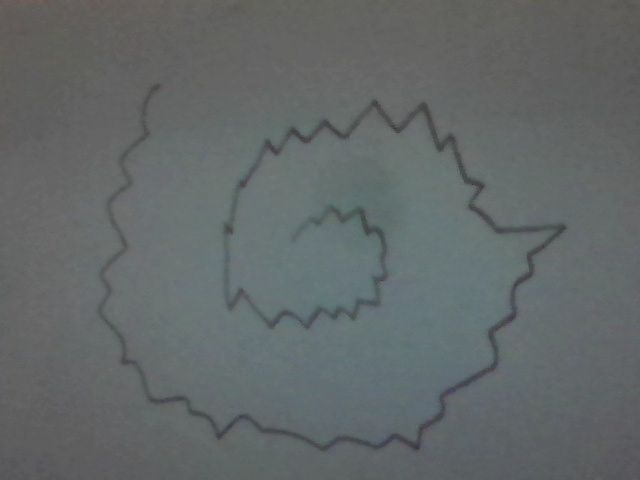

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: 1.00
Prediction: 1.00 - Parkinson Detected


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

# Function to take photo using Google Colab camera
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Prediction function using the model
def predict_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32')
    img = resnet_preprocess(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    print(f"Prediction: {prediction:.2f}")

    if prediction >= 0.5:
        result = f"Prediction: {prediction:.2f} - Parkinson Detected"
    else:
        result = f"Prediction: {prediction:.2f} - No Parkinson"

    return result


try:
    filename = take_photo()
    print(f"Saved to {filename}")
    display(Image(filename))

    # Make prediction
    result = predict_image(filename, model)
    print(result)

except Exception as e:
    print("Error:", str(e))


<IPython.core.display.Javascript object>

Saved to photo.jpg


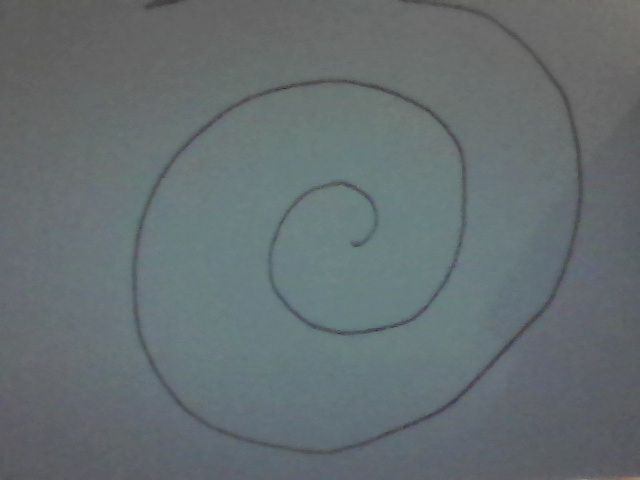

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Raw Score: 0.43
Prediction: Healthy (0.43)


In [20]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

model = load_model("ResNet50.h5")
# Web capture function
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (224, 224))
    img = cv2.equalizeHist(img)
    img = np.stack((img,)*3, axis=-1)
    img = img.astype('float32')
    img = resnet_preprocess(img)
    img = np.expand_dims(img, axis=0)
    return img


def predict_parkinson(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)[0][0]  # Output is a probability
    label = "Parkinson Detected" if prediction >= 0.5 else "Healthy"
    print(f"Raw Score: {prediction:.2f}")
    return f"Prediction: {label} ({prediction:.2f})"


try:
    filename = take_photo()
    print(f"Saved to {filename}")
    display(Image(filename))
    result = predict_parkinson(filename)
    print(result)
except Exception as e:
    print("Error:", str(e))
